# Data Loading and Generation

In [1]:
import os
if "aesthetix.py" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Speech%20Recognition/ds_utils/aesthetix.py
import numpy as np 
from sklearn.model_selection import train_test_split
import aesthetix as at

# Downloading movie_lines
if "movie_lines.txt" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Response%20Generation/movie_lines.txt

movielines = open("movie_lines.txt", mode='r')
print(movielines)
lines = movielines.readlines()
print(len(lines))

def clean_str(_str):
  _str = _str.strip()
  _str = _str.lower()
  _str = _str.replace(".", "")
  _str = _str.replace(",", "")
  _str = _str.replace("?", "")
  _str = _str.replace("!", "")
  _str = _str.replace(":", "")
  _str = _str.replace("-", " ")
  _str = _str.replace("_", " ")
  _str = _str.replace("\\", "")
  _str = _str.replace("  ", " ")
  return _str



<_io.TextIOWrapper name='movie_lines.txt' mode='r' encoding='UTF-8'>
304713


In [2]:
sample_size = 1000
cleanlines = []
for i, line in enumerate(lines[:sample_size]):
  at.progress_bar("Cleaning the lines", i, len(lines[:sample_size]))
  speaker, line = line.split('+++$+++ ')[-2:]
  cleanlines.append([speaker.split(" ")[0], line.split('\n')[0]])

cleanlines.reverse()
cleanlines = np.array(cleanlines)
for line in cleanlines[:10]:
  print(line[0],":",line[1])


# Forming the dataset 
response_data = []
l = len(cleanlines)-1
for i, line in enumerate(cleanlines[:-1]):
  at.progress_bar("Generating Stimulus-Response Pairs", i, l)
  speaker, utterance = line
  next_speaker, next_utterance = cleanlines[i+1]
  if speaker is not next_speaker:
    response_data.append(np.array([clean_str(utterance), clean_str(next_utterance)]))
  
response_data = np.array(response_data)
print(response_data.shape)
print(response_data[-10:])

Cleaning the lines:[==============================](100.00%)  
JORDY : Do you have coffee?
DAPHNE : In the kitchen.
JORDY : I'll make some for us.
DAPHNE : I'll get my clothes.
JORDY : What are you doing?
DAPHNE : Pouring it out!
DAPHNE : Forget about me.  You have enough problems of your own.
JORDY : ...Do you really want me to forget about you?
DAPHNE : I don't want to drag you down with me.
JORDY : Daphne, I...
Generating Stimulus-Response Pairs:[==============================](100.00%)  
(999, 2)
[['the "real you"' 'like my fear of wearing pastels']
 ['like my fear of wearing pastels'
  'i\'m kidding you know how sometimes you just become this "persona" and you don\'t know how to quit']
 ['i\'m kidding you know how sometimes you just become this "persona" and you don\'t know how to quit'
  'no']
 ['no' "okay  you're gonna need to learn how to lie"]
 ["okay  you're gonna need to learn how to lie" 'wow']
 ['wow' "let's go"]
 ["let's go" 'she okay']
 ['she okay' 'i hope so']
 ['i hope

In [3]:
# import pandas as pd
# a = pd.DataFrame({'Context': response_data[:, 0], 'Responses': response_data[:, 1]})
# a.to_csv("Dat.csv")

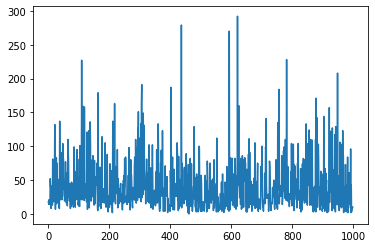

42.031031031031034
Longest utterance :  i realize that the men of this fine institution are severely lacking but killing yourself so you can be with william shakespeare is beyond the scope of normal teenage obsessions you're venturing far past daytime talk show fodder and entering the world of those who need very expensive therapy


In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline
a = [len(s) for s in response_data[:,0]]
# a_ = [s for s in response_data[:,0] if len(s)>2000]
plt.plot(a)
plt.show()
print(np.mean(np.array(a)))
print("Longest utterance : ", response_data[np.argmax(a), 0])

In [5]:
# Preprocessing the Data
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_token = "<OOV>"
max_length = 40
stimuli = response_data[:, 0]
responses = response_data[:, 1]

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(stimuli)

word_index = tokenizer.word_index
vocab_size = len(word_index)
stimulus_sequences = tokenizer.texts_to_sequences(stimuli)
response_sequences = tokenizer.texts_to_sequences(responses)

padded_stimulus_sequences = pad_sequences(stimulus_sequences, maxlen = max_length ,padding = 'post', truncating = 'post')
padded_response_sequences = pad_sequences(response_sequences, maxlen = max_length, padding = 'post', truncating = 'post')

In [6]:
# Getting the embedding weights from pre-trained glove vectors
embedding_dim = 100

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-20 13:27:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   185MB/s    in 1.8s    

2020-06-20 13:27:40 (185 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



# Attention Model

(Not going to use this one)

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM, RepeatVector, Concatenate, Dot, Activation, Input
from tensorflow.keras import backend as K
print(tf.__version__)
%matplotlib inline

2.2.0


In [10]:
# Main Model
def AttentionLayer(a, s_prev, maxlen):
  s_prev = RepeatVector(maxlen)(s_prev)
  concat = Concatenate()([a, s_prev])
  e = Dense(maxlen, activation='tanh')(concat)
  en = Dense(1, activation='relu')(e)
  alphas = Activation(lambda x:K.softmax(x, axis=1))(en)
  context = Dot(axes =1 )([alphas, a])
  return context


def ResponseGenModel(maxlen, post_attention_units, vocab_size, embedding_dim):

  X = Input(shape = (maxlen,), name ='X')
  s0 = Input(shape = (post_attention_units,), name = 's0')
  c0 = Input(shape = (post_attention_units,), name = 'c0')
  # y = input(shape = (maxlen,), name = 'y')

  Xemb = Embedding(input_dim=vocab_size+1,weights = [embeddings_matrix], output_dim=embedding_dim,trainable=False)(X)

  encoded = Bidirectional(LSTM(200, return_sequences = True))(Xemb)

  outputs = []
  s=s0
  c=c0

  for i in range(maxlen):
    context = AttentionLayer(encoded, s, maxlen)
    s, _, c = LSTM(post_attention_units, return_state = True)(context, initial_state = [s, c])
    out = Dense(vocab_size+1, activation='softmax')(s)
    outputs.append(out)
  
  return Model(inputs = [X, s0, c0], outputs =outputs)

In [11]:
# a = ResponseGenModel(30, 300, 5000, 100)
# a.summary()

In [12]:
def loss_func(y_true, y_pred):
  if tf.rank(y_true) < 2: return 0
  y_true = tf.keras.utils.to_categorical(np.array(y_true), num_classes = vocab_size+1)
  return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

In [13]:
# a.compile(loss = loss_func, metrics = ['accuracy'])
# b = a.predict([np.zeros((5, 30), dtype=int), np.zeros((5, 300)),np.zeros((5, 300))])

In [14]:
# np.array(b).shape

In [15]:
# Global Vars
post_attention_units = 400
print(f"vocab_size:{vocab_size}")
print(f"maxlen:{max_length}")
print(f"embedding_dim:{embedding_dim}")
print(f"post_attention_units:{post_attention_units}")

vocab_size:1829
maxlen:40
embedding_dim:100
post_attention_units:400


In [40]:
model = ResponseGenModel(maxlen=max_length, post_attention_units=post_attention_units, vocab_size=vocab_size, embedding_dim=embedding_dim)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 100)      183000      X[0][0]                          
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 400)]        0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 40, 400)      481600      embedding_3[0][0]                
____________________________________________________________________________________________

In [41]:
traingenie = DialogGen(padded_stimulus_sequences, padded_response_sequences, batch_size = 50,post_attention_cell_units=post_attention_units, vocab_size=vocab_size)
print(traingenie)
A = traingenie.__getitem__(0)
print(A[1].shape)
for a in A[0]:
  print(a.shape)

999
(40, 50, 1830)
(50, 40)
(50, 400)
(50, 400)


In [42]:
Y_ = model.predict(A[0])
print(np.array(Y_).shape)

(40, 50, 1830)


In [43]:
padded_response_seq = padded_response_sequences[:100]
padded_stimulus_seq = padded_stimulus_sequences[:100]

reg_batch_size = len(padded_response_seq)
s0 = np.zeros((reg_batch_size, post_attention_units))
c0 = np.zeros((reg_batch_size, post_attention_units))

padded_response_seq = tf.keras.utils.to_categorical(np.array(padded_response_seq), num_classes=vocab_size+1)


In [44]:
print(padded_response_seq.shape)

(100, 40, 1830)


# Encoder-Decoder with Attention


In [95]:
import tensorflow_addons as tfa

In [96]:
BATCH_SIZE = 64
BUFFER_SIZE = len(padded_response_sequences)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32   #used to initialize DecoderCell Zero state
Tx = max_length
Ty = max_length

In [114]:
class EncoderNet(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, embeddings_matrix):
    super(EncoderNet, self).__init__()
    self.encoder_embedding = tf.keras.layers.Embedding(input_dim = vocab_size+1,
                                                       output_dim = embedding_dim,
                                                       weights = [embeddings_matrix], trainable = False)
    self.encoder_rnnlayer = tf.keras.layers.LSTM(rnn_units,return_sequences = True, return_state = True)
  
# Decoder
class DecoderNet(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, embeddings_matrix):
    super(DecoderNet, self).__init__()
    self.decoder_embedding = tf.keras.layers.Embedding(input_dim = vocab_size+1,
                                                       output_dim = embedding_dim, weights = [embeddings_matrix], trainable= False)
    self.dense_layer = Dense(vocab_size)
    self.decoder_rnncell = tf.keras.layers.LSTMCell(rnn_units)
    #Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    self.attention_mechanism = self.build_attention_mechanism(dense_units, None, BATCH_SIZE*[Tx])
    self.rnn_cell = self.build_rnn_cell(BATCH_SIZE)
    self.decoder  = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler = self.sampler, output_layer = self.dense_layer)
  
  def build_attention_mechanism(self, units, memory, memory_sequence_length):
    return tfa.seq2seq.LuongAttention(units, memory= memory, memory_sequence_length=memory_sequence_length)
  
  def build_rnn_cell(self, batch_size):
    rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism, attention_layer_size = dense_units)
    return rnn_cell
  
  def build_decoder_initial_state(self, batch_size, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, dtype = Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state =encoder_state)
    return decoder_initial_state 
  


In [115]:
encoderNet = EncoderNet(vocab_size, embedding_dim, rnn_units, embeddings_matrix)
decoderNet = DecoderNet(vocab_size, embedding_dim, rnn_units, embeddings_matrix)


In [116]:
optimizer = tf.keras.optimizers.Adam()

In [117]:
def loss_function(y_pred, y):
  #shape of y [batch_size, ty]
  #shape of y_pred [batch_size, Ty, output_vocab_size] 
  sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                reduction='none')
  loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
  #skip loss calculation for padding sequences i.e. y = 0 
  #[ <start>,How, are, you, today, 0, 0, 0, 0 ....<end>]
  #[ 1, 234, 3, 423, 3344, 0, 0 ,0 ,0, 2 ]
  # y is a tensor of [batch_size,Ty] . Create a mask when [y=0]
  # mask the loss when padding sequence appears in the output sequence
  mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss

In [118]:
decoderNet.attention_mechanism.memory_initialized

False

In [105]:
def train_step(input_batch, output_batch, encoder_initial_cell_state):
  loss = 0
  with tf.GradientTape() as tape:
      encoder_emb_inp = encoderNet.encoder_embedding(input_batch)
      a, a_tx, c_tx = encoderNet.encoder_rnnlayer(encoder_emb_inp, 
                                                      initial_state =encoder_initial_cell_state)

      #[last step activations,last memory_state] of encoder passed as input to decoder Network
      
        
      # Prepare correct Decoder input & output sequence data
      decoder_input = output_batch[:,:-1] # ignore <end>
      #compare logits with timestepped +1 version of decoder_input
      decoder_output = output_batch[:,1:] #ignore <start>


      # Decoder Embeddings
      decoder_emb_inp = decoderNet.decoder_embedding(decoder_input)

      #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
      decoderNet.attention_mechanism.setup_memory(a)
      decoder_initial_state = decoderNet.build_decoder_initial_state(BATCH_SIZE,
                                                                          encoder_state=[a_tx, c_tx],
                                                                          Dtype=tf.float32)
      
      #BasicDecoderOutput        
      outputs, _, _ = decoderNet.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                              sequence_length=BATCH_SIZE*[Ty-1])

      logits = outputs.rnn_output
      #Calculate loss

      loss = loss_function(logits, decoder_output)

  #Returns the list of all layer variables / weights.
  variables = encoderNet.trainable_variables + decoderNet.trainable_variables  
  # differentiate loss wrt variables
  gradients = tape.gradient(loss, variables)

  #grads_and_vars – List of(gradient, variable) pairs.
  grads_and_vars = zip(gradients,variables)
  optimizer.apply_gradients(grads_and_vars)
  return loss

In [110]:
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]

In [119]:
# Initialising the dataset
dataset = tf.data.Dataset.from_tensor_slices((padded_stimulus_sequences, padded_response_sequences)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
example_X, example_Y = next(iter(dataset))
print(example_X.shape) 
print(example_Y.shape)

(64, 40)
(64, 40)


In [123]:
epochs = 10
print("Training :")
for i in range(1, epochs+1):
    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0
    for ( batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        at.progress_bar(f"Epoch {i}/{epochs}", batch, steps_per_epoch, output_vals = {'Loss' : total_loss})
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss

Training :
Epoch 1/10:[===============](100.00%)  Loss : 16.84 
Epoch 2/10:[===============](100.00%)  Loss : 16.38 
Epoch 3/10:[===============](100.00%)  Loss : 15.47 
Epoch 4/10:[===============](100.00%)  Loss : 15.25 
Epoch 5/10:[===============](100.00%)  Loss : 14.51 
Epoch 6/10:[===============](100.00%)  Loss : 14.19 
Epoch 7/10:[===============](100.00%)  Loss : 13.35 
Epoch 8/10:[===============](100.00%)  Loss : 12.82 
Epoch 9/10:[===============](100.00%)  Loss : 11.86 
Epoch 10/10:[===============](100.00%)  Loss : 11.12 
